In [15]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
import numpy as np
from PIL import Image
import glob
import os
from sklearn.model_selection import train_test_split
from math import log, exp
from time import time
import matplotlib.pyplot as plt
import matplotlib.animation as anim
from copy import deepcopy

In [13]:
class Booster:
    def __init__(self, n_estimators=50, learning_rate=1, random_state=None, base_learner=DecisionTreeClassifier(max_depth=2)):
        self.n_estimators_ = n_estimators
        self.learning_rate_ = learning_rate
        self.random_state_ = random_state
        self.estimators_ = []
        self.alphas_ = np.zeros(self.n_estimators_)
        self.accuracies = None
        self.base_learner_ = base_learner
    
    def plot(self):
        if not self.accuracies:
            raise ValueError("ERROR: self.accuracies not defined. Make sure self.fit() is called with visible=True")
        plt.plot([i+1 for i in range(self.n_estimators_)],self.accuracies)
        plt.xlabel("Number of estimators")
        plt.ylabel("Accuracy")
        plt.show()

    def fit(self, X, Y, verbose=False, visible=False, verbose_visibility=False):
        if visible:
            self.accuracies = []
            
        self.n_samples_ = X.shape[0]
        self.classes_ = np.array(sorted(list(set(Y))))
        self.n_classes_ = len(self.classes_)
        for i in range(self.n_estimators_):
            if i == 0:
                if verbose:
                    print(f"Iteration starting after {time()-start:.2f} seconds")
                local_alphas = np.ones(self.n_samples_) / self.n_samples_
            local_weights, estimator_alpha, estimator_error = self.boost(X, Y, local_alphas, visible)
            
            if estimator_error is None:
                break
            
            self.alphas_[i] = estimator_alpha
            
            if verbose and (i+1) % verbose == 0:
                print(f"Iteration {i+1} ended after {time()-start:.2f} seconds")
            
            if visible:
                acc_start = time()
                self.accuracies.append(self.accuracy(self.predict(X),Y))
                if verbose_visibility and (i+1) % verbose_visibility == 0:
                    print(f"Accuracy {i+1} ({self.accuracies[-1]:.2%}) took {time()-acc_start:.2f} seconds")
                
            if estimator_error <= 0:
                break
        
        if visible:
            self.plot()
        
        return self
    
    def boost(self, X, Y, weights, visible):
        estimator = deepcopy(self.base_learner_)
        if self.random_state_:
            estimator.set_params(random_state=1)

        estimator.fit(X, Y, sample_weight=weights)

        y_hat = estimator.predict(X)
        incorrect = y_hat != Y
        estimator_error = np.dot(incorrect, weights) / np.sum(weights, axis=0)

        if estimator_error >= 1 - 1 / self.n_classes_:
            return None, None, None

        estimator_weight = self.learning_rate_ * np.log((1 - estimator_error) / estimator_error) + np.log(self.n_classes_ - 1)

        if estimator_weight <= 0:
            return None, None, None

        weights *= np.exp(estimator_weight * incorrect)

        w_sum = np.sum(weights, axis=0)
        if w_sum <= 0:
            return None, None, None

        weights /= w_sum

        self.estimators_.append(estimator)

        return np.array(weights), estimator_weight, estimator_error

    def predict(self, X):
        n_classes = self.n_classes_
        classes = self.classes_[:, np.newaxis]
        pred = sum((estimator.predict(X) == classes).T * a for estimator, a in zip(self.estimators_, self.alphas_))
        pred /= self.alphas_.sum()
        if n_classes == 2:
            pred[:, 0] *= -1
            pred = pred.sum(axis=1)
            return self.classes_.take(pred > 0, axis=0)
        
        return self.classes_.take(np.argmax(pred, axis=1), axis=0)
    
    def accuracy(self, y_hat, y_true):
        ones = np.where(y_hat == y_true, 1, 0)
        solid = np.ones((1,len(y_hat)))
        return ((ones @ ones.T) / (solid @ solid.T))[0][0]
    

In [10]:
import tensorflow as tf
import keras
from keras.datasets import mnist, fashion_mnist

In [11]:
(Xtrain,Ytrain), (Xtest,Ytest) = mnist.load_data()
Xtrain = Xtrain.astype("float32") / 255.
Xtest = Xtest.astype("float32") / 255.
Xtrain = Xtrain.reshape((len(Xtrain), np.prod(Xtrain.shape[1:])))
Xtest = Xtest.reshape((len(Xtest), np.prod(Xtest.shape[1:])))
print(Xtrain.shape)
print(Xtest.shape)

(60000, 784)
(10000, 784)


Iteration starting after 0.01 seconds
Iteration 25 ended after 79.81 seconds
Accuracy 25 (70.24%) took 1.44 seconds
Iteration 50 ended after 199.25 seconds
Accuracy 50 (78.09%) took 2.75 seconds
Iteration 75 ended after 359.33 seconds
Accuracy 75 (79.96%) took 4.23 seconds
Iteration 100 ended after 545.52 seconds
Accuracy 100 (81.08%) took 6.58 seconds
Iteration 125 ended after 767.08 seconds
Accuracy 125 (83.66%) took 6.97 seconds
Iteration 150 ended after 1021.91 seconds
Accuracy 150 (83.78%) took 8.15 seconds
Iteration 175 ended after 1310.11 seconds
Accuracy 175 (84.29%) took 10.71 seconds
Iteration 200 ended after 1657.65 seconds
Accuracy 200 (85.00%) took 14.22 seconds
Iteration 225 ended after 2105.37 seconds
Accuracy 225 (84.58%) took 15.36 seconds
Iteration 250 ended after 2547.21 seconds
Accuracy 250 (85.51%) took 14.45 seconds
Iteration 275 ended after 2976.63 seconds
Accuracy 275 (85.36%) took 15.01 seconds
Iteration 300 ended after 3463.16 seconds
Accuracy 300 (85.35%) too

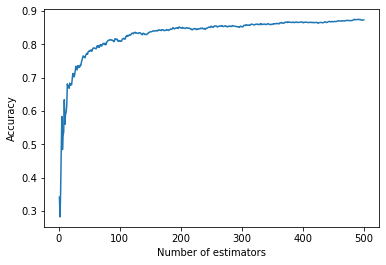

Accuracy: 87.35% over 500 trees after 8639.75 seconds


In [17]:
start = time()
n_estimators=500
booster = Booster(n_estimators = n_estimators, base_learner=DecisionTreeClassifier(max_depth=2)).fit(Xtrain, Ytrain, verbose=25, visible=True, verbose_visibility=25)
y_hat = booster.predict(Xtrain)
print(f"Accuracy: {booster.accuracy(y_hat, Ytrain):.2%} over {n_estimators} trees after {time()-start:.2f} seconds")

Iteration starting after 0.01 seconds
Iteration 25 ended after 50.87 seconds
Accuracy 25 (47.40%) took 1.38 seconds
Iteration 50 ended after 134.11 seconds
Accuracy 50 (57.53%) took 2.59 seconds
Iteration 75 ended after 249.32 seconds
Accuracy 75 (67.15%) took 3.86 seconds
Iteration 100 ended after 396.46 seconds
Accuracy 100 (70.12%) took 5.21 seconds
Iteration 125 ended after 576.07 seconds
Accuracy 125 (71.73%) took 6.40 seconds
Iteration 150 ended after 787.01 seconds
Accuracy 150 (73.47%) took 7.61 seconds
Iteration 175 ended after 1030.94 seconds
Accuracy 175 (74.01%) took 8.93 seconds
Iteration 200 ended after 1307.05 seconds
Accuracy 200 (75.35%) took 10.47 seconds
Iteration 225 ended after 1614.59 seconds
Accuracy 225 (76.25%) took 11.34 seconds
Iteration 250 ended after 1952.67 seconds
Accuracy 250 (76.39%) took 13.47 seconds
Iteration 275 ended after 2325.49 seconds
Accuracy 275 (76.10%) took 13.86 seconds
Iteration 300 ended after 2737.52 seconds
Accuracy 300 (77.00%) took 

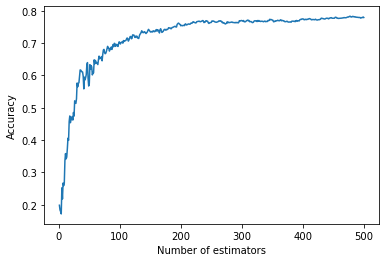

Accuracy: 77.91% over 500 trees after 7182.45 seconds


In [18]:
start = time()
n_estimators=500
booster = Booster(n_estimators = n_estimators, base_learner=DecisionTreeClassifier(max_depth=1)).fit(Xtrain, Ytrain, verbose=25, visible=True, verbose_visibility=25)
y_hat = booster.predict(Xtrain)
print(f"Accuracy: {booster.accuracy(y_hat, Ytrain):.2%} over {n_estimators} trees after {time()-start:.2f} seconds")

Iteration starting after 0.01 seconds
Iteration 25 ended after 105.61 seconds
Accuracy 25 (81.09%) took 1.46 seconds
Iteration 50 ended after 246.35 seconds
Accuracy 50 (85.25%) took 2.71 seconds
Iteration 75 ended after 420.19 seconds
Accuracy 75 (86.91%) took 4.03 seconds
Iteration 100 ended after 628.58 seconds
Accuracy 100 (88.26%) took 5.40 seconds
Iteration 125 ended after 871.81 seconds
Accuracy 125 (89.08%) took 6.70 seconds
Iteration 150 ended after 1154.77 seconds
Accuracy 150 (89.92%) took 9.92 seconds
Iteration 175 ended after 1482.82 seconds
Accuracy 175 (90.17%) took 10.16 seconds
Iteration 200 ended after 1825.78 seconds
Accuracy 200 (90.33%) took 10.69 seconds
Iteration 225 ended after 2202.25 seconds
Accuracy 225 (90.86%) took 12.99 seconds
Iteration 250 ended after 2621.10 seconds
Accuracy 250 (91.05%) took 14.08 seconds
Iteration 275 ended after 3068.25 seconds
Accuracy 275 (91.22%) took 14.77 seconds
Iteration 300 ended after 3547.13 seconds
Accuracy 300 (91.69%) to

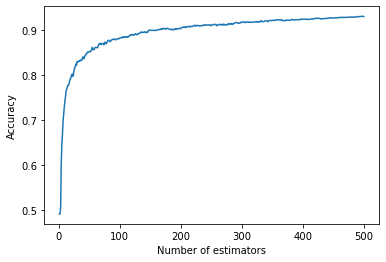

Accuracy: 93.00% over 500 trees after 8659.01 seconds


In [19]:
start = time()
n_estimators=500
booster = Booster(n_estimators = n_estimators, base_learner=DecisionTreeClassifier(max_depth=3)).fit(Xtrain, Ytrain, verbose=25, visible=True, verbose_visibility=25)
y_hat = booster.predict(Xtrain)
print(f"Accuracy: {booster.accuracy(y_hat, Ytrain):.2%} over {n_estimators} trees after {time()-start:.2f} seconds")